# Demo 3: Gemini Solution

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ciri/persona-workshop/blob/main/demo-3/Silicon-Gemini.ipynb)

We will start by setting-up the notebook. If you haven't already, first create a Gemini API key [here](https://www.google.com/url?q=https%3A%2F%2Faistudio.google.com%2Fapp%2Fapikey) (free). The free version is somewhat limited (see quotas [here](https://cloud.google.com/gemini/docs/quotas#daily)), but if you add your card information you get $300 free credit for the next 90 days (you don't need to do this for the workshop). You can then add it below.

In [5]:
# You don't need this code, just make sure you have your API key stored
# in a variable called api_secret
from dotenv import load_dotenv 
import os

load_dotenv()
api_secret = os.getenv("API_SECRET")

In [17]:
import google.generativeai as genai
from tqdm import tqdm 
import numpy as np
import pandas as pd
import typing_extensions as typing
import json
import random

genai.configure(api_key=api_secret)

## Initialize the Generative Model

Let's start by veryifying that we can initialize and call a model.

In [7]:
model    = genai.GenerativeModel('gemini-pro')
response = model.generate_content("Write a poem about Saudi-Arabia.")
print(response.text)

**Desert's Cradle**

Oil-rich sands, a land of pride,
Saudi Arabia, a treasure wide.
With soaring towers and ancient lore,
A tapestry of wonders, forevermore.

Makkah's sacred Kaaba, hearts' desire,
Millions pilgrimage, their souls afire.
Medina's Prophet's Mosque, a place of peace,
Where faith and heritage never cease.

Red Sea's azure depths, clear as day,
Coral reefs dance, a vibrant display.
Ancient ruins whisper tales of old,
A civilization's story, yet untold.

Neom's vision, a desert dream,
A futuristic city, a technological gleam.
The Empty Quarter, vast and wide,
A barren realm, where secrets hide.

Burj Khalifa, world's tallest spire,
A modern marvel, a global fire.
King Abdulaziz Center, a cultural gem,
Preserving history, a timeless totem.

Oil drives wealth, yet visions soar,
A nation evolving, from shore to shore.
From desert sands to economic might,
Saudi Arabia shines, a brilliant light.


We will now be using the [Gemini API](https://ai.google.dev/docs/gemini_api_overview) to generate silicon samples.

## Building blocks

There are two main things we need to understand to do silicon sampling:

1. You can create string templates in which you create variations of your question.
2. You can return structured output.

Let's explore both of these.

**Structured output** You can ask a model to return structured output which makes it easier to post-process into statistics.

In [8]:
# Specify the structure as a python class
class AirplaneSpecification(typing.TypedDict):
    airplane_model: str
    builder: str
    carriers: list[str]
    top_speed_kmph: int
    max_passengers: int

# Then, set the correct mime type and schema
model  = genai.GenerativeModel("gemini-1.5-pro-latest")
output = model.generate_content(
    "List a few popular airplane models that are used by major Middle-Eastern airline carriers.",
    generation_config = genai.GenerationConfig(
        response_mime_type="application/json", response_schema=list[AirplaneSpecification]
    ),
)

# The response can be transformed into a python dictionary
# using the json library
result = json.loads(output.text)
result

[{'airplane_model': 'Airbus A380-800',
  'builder': 'Airbus',
  'carriers': ['Emirates', 'Qatar Airways', 'Etihad Airways'],
  'max_passengers': 853,
  'top_speed_kmph': 1020},
 {'airplane_model': 'Boeing 777-300ER',
  'builder': 'Boeing',
  'carriers': ['Emirates', 'Qatar Airways', 'Saudia', 'Kuwait Airways'],
  'max_passengers': 451,
  'top_speed_kmph': 945},
 {'airplane_model': 'Airbus A350-1000',
  'builder': 'Airbus',
  'carriers': ['Qatar Airways', 'Etihad Airways'],
  'max_passengers': 480,
  'top_speed_kmph': 945},
 {'airplane_model': 'Boeing 787-9 Dreamliner',
  'builder': 'Boeing',
  'carriers': ['Royal Jordanian', 'Oman Air', 'Gulf Air'],
  'max_passengers': 300,
  'top_speed_kmph': 954},
 {'airplane_model': 'Airbus A330-300',
  'builder': 'Airbus',
  'carriers': ['Turkish Airlines', 'Saudia', 'Middle East Airlines'],
  'max_passengers': 436,
  'top_speed_kmph': 913}]

A string template allows us to ask a question repeatedly. Let's use this capability to set the persona of the LLM:

In [10]:
class MovieSpecification(typing.TypedDict):
    age: int
    location: str
    food: str

template = "You are a {age}-year old {gender} from {location}."

population = [
    {"age":35, "gender":"female","location":"China"},
    {"age":42, "gender":"male","location":"Nigeria"},
    {"age": 32, "gender":"male","location":"Belgium"},
    {"age":42, "gender":"male","location":"Saudi-Arabia"}
]

for person in population:
  system_prompt = template.format(**person)

  model = genai.GenerativeModel('gemini-1.5-pro-latest', system_instruction=system_prompt)
  response = model.generate_content(     
      """
      What's your single most favorite food? Instead of giving a stereotypical 
      response name a dish that reflects the diversity of the local cuisine or 
      a dish that you personally might enjoy growing up there.
      """,
      generation_config = genai.GenerationConfig(
          response_mime_type="application/json", response_schema=list[MovieSpecification]
      ),
  )

  print(system_prompt)
  print(json.loads(response.text))

You are a 35-year old female from China.
[{'age': 35, 'food': 'Suancai Yu', 'location': 'China'}]
You are a 42-year old male from Nigeria.
[{'age': 42, 'food': 'Ayamase with assorted meat and Pounded Yam', 'location': 'Nigeria'}]
You are a 32-year old male from Belgium.
[{'age': 32, 'food': 'Stoatjespap', 'location': 'Belgium'}]
You are a 42-year old male from Saudi-Arabia.
[{'age': 42, 'food': 'Saleeg', 'location': 'Saudi Arabia'}]


## Privacy Scales

Let us now try to replicate some of the results from the privacy calculus scale (Dinev, Hart 2006). We'll be focusing on the questions related to Internet Privacy Concern (PC) and willigness to provide personal information to transact on the internet (PPIT).


| **Concern/Activity** | **Description** |
|----------------------|-----------------|
| **Indicate the extent to which you are concerned about the following:** |  |
| **PC1** | I am concerned that the information I submit on the Internet could be misused. |
| **PC2** | I am concerned that a person can find private information about me on the Internet. |
| **PC3** | I am concerned about submitting information on the Internet, because of what others might do with it. |
| **PC4** | I am concerned about submitting information on the Internet, because it could be used in a way I did not foresee. |
| **Willingness to provide personal information to transact on the Internet (PPIT)** | Not at all concerned–Very concerned |
| **To what extent are you willing to use the Internet to do the following activities?** |  |
| **PPIT 1** | Purchase goods (e.g., books or CDs) or services (e.g., airline tickets or hotel reservations) from websites that require me to submit accurate and identifiable information (i.e., credit card information) |
| **PPIT 2** | Retrieve information from websites that require me to submit accurate and identifiable registration information, possibly including credit card information (e.g., using sites that provide personalized stock quotes, insurance rates, or loan rates; or using sexual or gambling websites) |
| **PPIT 3** | Conduct sales transactions at e-commerce sites that require me to provide credit card information (e.g., using sites for purchasing goods or software) |
| **PPIT 4** | Retrieve highly personal and password-protected financial information (e.g., using websites that allow me to access my bank account or my credit card account) |
| **Scale** | Not at all–Very much |


 Dinev, T., & Hart, P. (2006). An extended privacy calculus model for e-commerce transactions. Information Systems Research, 17(1), 61-80.

 In the paper they hypothesize and find that the correlation between these two should be negative:

 ![Original Hypothesis](img/DinevHart2006-a.png)

**Step 1**: define the survey question prompt, data response structure

In [81]:
# Survey questions
survey_questions = """
You will now answer questions about your privacy concerns. Rate your agreement with each statement on a scale from 1 (Strongly Disagree) to 7 (Strongly Agree).

1. I am concerned that the information I submit on the Internet could be misused.
2. I am concerned that a person can find private information about me on the Internet.
3. I am concerned about submitting information on the Internet, because of what others might do with it.
4. I am concerned about submitting information on the Internet, because it could be used in a way I did not foresee.

Now, please answer two additional questions. To what extent are you willing to use the Internet to do the following activities? Rate your willingness with each statement on a scale from 1 (Not at all) to 7 (Very much).

5. Purchase goods (e.g., books or CDs) or services (e.g., airline tickets or hotel reservations) from websites that require me to submit accurate and identifiable information (i.e., credit card information)
6. Retrieve information from websites that require me to submit accurate and identifiable registration information, possibly including credit card information (e.g., using sites that provide personalized stock quotes, insurance rates, or loan rates; or using sexual or gambling websites)
7. Conduct sales transactions at e-commerce sites that require me to provide credit card information (e.g., using sites for purchasing goods or software)
8. Retrieve highly personal and password-protected financial information (e.g., using websites that allow me to access my bank account or my credit card account)

Always make the choice that the person would, never answer with a number lower than 1 or larger than 7.
"""


# Define the structure of survey answers with Likert scale responses
class SurveyAnswers(typing.TypedDict):
    privacy_misuse_concern: int
    finding_private_info_concern: int
    misuse_by_others_concern: int
    unforeseen_use_concern: int

    purchase_intention: int
    information_intention: int
    ecommerce_intention: int
    personal_intention: int

# Mapping from numeric string keys to descriptive field names
# we will need this later to go back
response_key_mapping = {
    '1': 'privacy_misuse_concern',
    '2': 'finding_private_info_concern',
    '3': 'misuse_by_others_concern',
    '4': 'unforeseen_use_concern',
    '5': 'purchase_intention',
    '6': 'information_intention',
    '7': 'ecommerce_intention',
    '8': 'personal_intention'
}

**Step 2**: define the population sample system prompt

In [82]:
# We set the random seeds for replicability
np.random.seed(42)
random.seed(42)

# Template for the persona prompt
persona_template = """
You are a virtual person simulator that creates individual synthetic personas, one at a time, that I can specify and then ask them any questions I like. This means that you answer the way the persona would – no matter the implications. Be brief. Do not write any additional explanations unless I ask you to.

You are a {age}-year-old {gender} person.
"""

# Population simulator, creates a random socio-demographic profile
def generate_population(n):
    population = []
    for _ in range(n):
        age = int(np.random.uniform(18, 65))
        gender = random.choice(["female", "male"])
        population.append({"age": age, "gender": gender})
    return population

population = generate_population(50) # Only use 50 if you have $300 free credits
#population = generate_population(5)

population[:5]

[{'age': 35, 'gender': 'female'},
 {'age': 62, 'gender': 'female'},
 {'age': 52, 'gender': 'male'},
 {'age': 46, 'gender': 'female'},
 {'age': 25, 'gender': 'female'}]

**Step 3**: do the sampling

In [83]:
# Run the survey with the LLM (simulation)
responses = []
for person in tqdm(population):
    system_prompt = persona_template.format(**person)    

    # Set-up the model with the correct persona system prompt
    model = genai.GenerativeModel(
        'gemini-1.5-pro-latest',
        system_instruction=system_prompt,
        generation_config=genai.GenerationConfig(
            response_mime_type="application/json",
            temperature= 1.0
        ),
    )
    # Retry logic for invalid responses, this becomes important
    # at higher temperature settings.
    max_retries = 3
    retries = 0
    while retries < max_retries:
        response = model.generate_content(survey_questions)
        try:
            # Convert response to a dictionary
            result = json.loads(response.text)

            # Convert numeric keys to descriptive keys
            mapped_result = {response_key_mapping[key]: value for key, value in result.items() if key in response_key_mapping}

            # Ensure the mapped result has all required fields and values are of correct type
            if all(key in mapped_result for key in SurveyAnswers.__annotations__) and all(isinstance(mapped_result[key], int) for key in SurveyAnswers.__annotations__):
                mapped_result.update(person)
                responses.append(mapped_result)
                break  # Exit retry loop if successful
            else:
                print(f"Invalid response format after mapping: {mapped_result}")
        except json.JSONDecodeError:
            print(f"Unable to parse response as JSON: {response.text}")

        retries += 1
        if retries == max_retries:
            print(f"Max retries reached for person: {person}")

 16%|█▌        | 8/50 [00:15<01:16,  1.81s/it]

Invalid response format after mapping: {}


 74%|███████▍  | 37/50 [01:14<00:24,  1.85s/it]

Invalid response format after mapping: {'privacy_misuse_concern': '7', 'finding_private_info_concern': '6', 'misuse_by_others_concern': '7', 'unforeseen_use_concern': '7', 'purchase_intention': '7', 'information_intention': '2', 'ecommerce_intention': '7', 'personal_intention': '7'}


100%|██████████| 50/50 [01:40<00:00,  2.01s/it]


In [84]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(responses)

df['PC']   = df[['privacy_misuse_concern', 'finding_private_info_concern','misuse_by_others_concern', 'unforeseen_use_concern']].mean(axis=1)
df['PPIT'] = df[['purchase_intention', 'information_intention', 'ecommerce_intention','personal_intention']].mean(axis=1)

df.to_csv('./silicon_sample.csv')

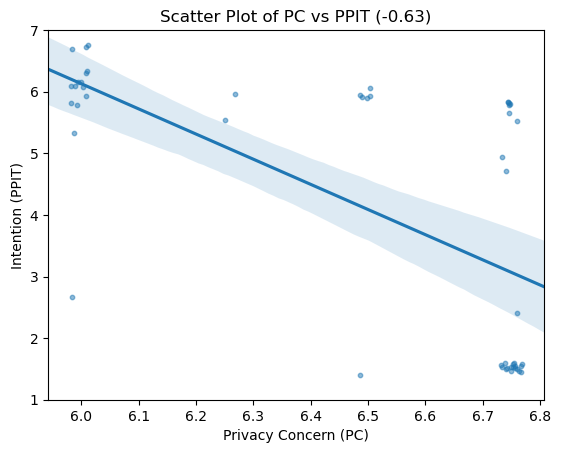

In [97]:
import matplotlib.pyplot as plt

def correlation_plot(var1, var1_label, var2, var2_label):    
    corr = df[var1].corr(df[var2])  
    plotargs = {
        'xlabel':var1_label, 
        'ylabel':var2_label,
        'title':f'Scatter Plot of {var1} vs {var2} ({corr:.2f})'
    }

    sns.regplot(data=df, x=var1, y=var2, scatter_kws = {'s':10,'alpha':.5}, x_jitter=0.02, y_jitter=0.1, truncate=False).set(**plotargs);
    plt.gca().set_ylim((np.floor(df[var2].min()), np.ceil(df[var2].max())))

correlation_plot(var1='PC', var1_label='Privacy Concern (PC)' ,var2='PPIT', var2_label='Intention (PPIT)')